# Step 1: Installation and Configuration

In [1]:
pip install kaggle

In [13]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
from google.colab import files

In [15]:
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [16]:
! cp kaggle.json ~/.kaggle

In [17]:
! chmod 600 /root/.kaggle/kaggle.json

In [18]:
! kaggle datasets list

ref                                                      title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                          DAIGT V2 Train Dataset                           29MB  2023-11-16 01:38:36           2133        201  1.0              
thedrcat/daigt-proper-train-dataset                      DAIGT Proper Train Dataset                      119MB  2023-11-05 14:03:25           1927        156  1.0              
muhammadbinimran/housing-price-prediction-data           Housing Price Prediction Data                   763KB  2023-11-21 17:56:32           9824        166  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset           LLM: 7 prompt training dataset                   41MB  202

In [19]:
! kaggle datasets download -d felipekitamura/spr-x-ray-age-and-gender-dataset

... resuming from 5846859776 bytes (10899141331 bytes left) ...
100% 15.6G/15.6G [01:42<00:00, 83.6MB/s]
100% 15.6G/15.6G [01:42<00:00, 107MB/s] 


In [28]:
! ls

kaggle	kaggle.json  sample_data  spr-x-ray-age-and-gender-dataset.zip


In [30]:
! pwd

/content


In [41]:
! ls

kaggle.json  sample_data  spr-x-ray-age-and-gender-dataset.zip


In [42]:
! mkdir data/

In [43]:
! ls -lta

total 16353548
drwxr-xr-x 1 root root        4096 Dec 19 09:51 .
drwxr-xr-x 2 root root        4096 Dec 19 09:51 data
-rw-r--r-- 1 root root          70 Dec 19 09:37 kaggle.json
drwxr-xr-x 1 root root        4096 Dec 19 09:27 ..
drwxr-xr-x 1 root root        4096 Dec 15 14:24 sample_data
drwxr-xr-x 4 root root        4096 Dec 15 14:23 .config
-rw-r--r-- 1 root root 16746001107 Mar 10  2023 spr-x-ray-age-and-gender-dataset.zip


In [47]:
! unzip spr-x-ray-age-and-gender-dataset.zip -d /data/

Streaming output truncated to the last 5000 lines.
  inflating: /data/kaggle/kaggle/train/005706.png  
  inflating: /data/kaggle/kaggle/train/005707.png  
  inflating: /data/kaggle/kaggle/train/005708.png  
  inflating: /data/kaggle/kaggle/train/005709.png  
  inflating: /data/kaggle/kaggle/train/005710.png  
  inflating: /data/kaggle/kaggle/train/005711.png  
  inflating: /data/kaggle/kaggle/train/005712.png  
  inflating: /data/kaggle/kaggle/train/005713.png  
  inflating: /data/kaggle/kaggle/train/005714.png  
  inflating: /data/kaggle/kaggle/train/005715.png  
  inflating: /data/kaggle/kaggle/train/005716.png  
  inflating: /data/kaggle/kaggle/train/005717.png  
  inflating: /data/kaggle/kaggle/train/005718.png  
  inflating: /data/kaggle/kaggle/train/005719.png  
  inflating: /data/kaggle/kaggle/train/005720.png  
  inflating: /data/kaggle/kaggle/train/005721.png  
  inflating: /data/kaggle/kaggle/train/005722.png  
  inflating: /data/kaggle/kaggle/train/005723.png  
  inflating: 

# Step 2: Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
from PIL import Image

In [3]:
! ls

data  gender_model.h5  kaggle.json  sample_data  spr-x-ray-age-and-gender-dataset.zip


In [4]:
base_data_dir = "/data/"

In [5]:
df_gender = pd.read_csv(base_data_dir + "train_gender.csv")
df_age = pd.read_csv(base_data_dir + "train_age.csv")

In [6]:
print(df_gender)

       imageId  gender
0            0       0
1            1       0
2            2       1
3            3       1
4            4       0
...        ...     ...
10697    10697       0
10698    10698       0
10699    10699       1
10700    10700       0
10701    10701       1

[10702 rows x 2 columns]


In [7]:
print(df_age)

       imageId   age
0            0  89.0
1            1  72.0
2            2  25.0
3            3  68.0
4            4  37.0
...        ...   ...
10697    10697  79.0
10698    10698  67.0
10699    10699  66.0
10700    10700  78.0
10701    10701  74.0

[10702 rows x 2 columns]


In [8]:
images = []
for i in tqdm(sorted(os.listdir(base_data_dir + "kaggle/kaggle/train/"))):
  img = cv2.imread(base_data_dir + "kaggle/kaggle/train/" + i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = 255 - img
  img = cv2.resize(img, (128, 128))
  images.append(img)
age = df_age["age"]
gender = df_gender["gender"]
data = {"Image": images, "Age": age, "Gender": gender}

100%|██████████| 10702/10702 [07:09<00:00, 24.89it/s]


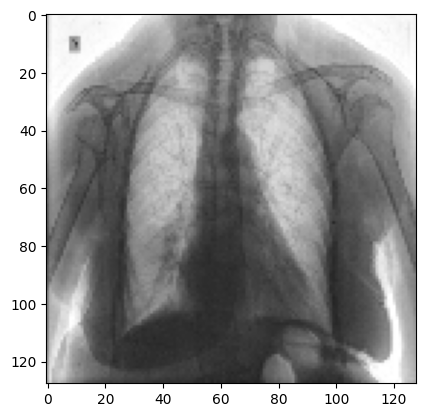

In [9]:
df = pd.DataFrame(data)
plt.imshow(cv2.cvtColor(df["Image"].iloc[0], cv2.COLOR_BGR2RGB))

# Step 3: Gender Prediction

In [10]:
X = np.array(data["Image"])
y = np.array(data["Gender"])

X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
y = y.reshape(-1, 1)
X = X / 255
print(X.shape,  y.shape)

(10702, 128, 128, 1) (10702, 1)


In [11]:
! pip install tensorflow

In [12]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization, Input

In [13]:
def create_block(y, filter, kernel):
  x = Conv2D(filter, kernel, strides=2, padding="same")(y)
  x = MaxPool2D(2, strides = 2, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

In [14]:
# Creating the model
tensorflow.keras.backend.clear_session()
gender_model = tensorflow.keras.Sequential()

input_layer = Input((128, 128, 1))
c0 = Conv2D(4, 3, padding="same")(input_layer)
c0 = MaxPool2D(2)(c0)

c1 = create_block(c0, 16, 3)
c2 = create_block(c1, 32, 3)
c3 = create_block(c2, 64, 3)
c4 = create_block(c3, 128, 3)
c5 = create_block(c4, 64, 3)
c6 = create_block(c5, 32, 3)
c6 = GlobalAveragePooling2D()(c6)

output = Dense(1, activation="sigmoid")(c6)
gender_model = Model(inputs=[input_layer], outputs=[output])

In [15]:
gender_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gender_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 4)       40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 16)        64    

In [16]:
history =  gender_model.fit(
    X, y,
    steps_per_epoch = (10000//10),
    validation_split=0.2,
    epochs=10
)

Epoch 1/10
1000/1000 [==============================] - 66s 62ms/step - loss: 0.4947 - accuracy: 0.7699 - val_loss: 0.4337 - val_accuracy: 0.8174
Epoch 2/10
1000/1000 [==============================] - 62s 62ms/step - loss: 0.3786 - accuracy: 0.8373 - val_loss: 0.3431 - val_accuracy: 0.8459
Epoch 3/10
1000/1000 [==============================] - 58s 58ms/step - loss: 0.3604 - accuracy: 0.8540 - val_loss: 0.5769 - val_accuracy: 0.6544
Epoch 4/10
1000/1000 [==============================] - 59s 59ms/step - loss: 0.3138 - accuracy: 0.8722 - val_loss: 0.2464 - val_accuracy: 0.9043
Epoch 5/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.3060 - accuracy: 0.8761 - val_loss: 0.3108 - val_accuracy: 0.8692
Epoch 6/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.2807 - accuracy: 0.8915 - val_loss: 0.3725 - val_accuracy: 0.8356
Epoch 7/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.2527 - accuracy: 0.9043 - val_loss: 0.2058 -

1000/1000 [==============================] - 39s 39ms/step - loss: 0.2407 - accuracy: 0.9093 - val_loss: 0.2042 - val_accuracy: 0.9271


<Axes: >

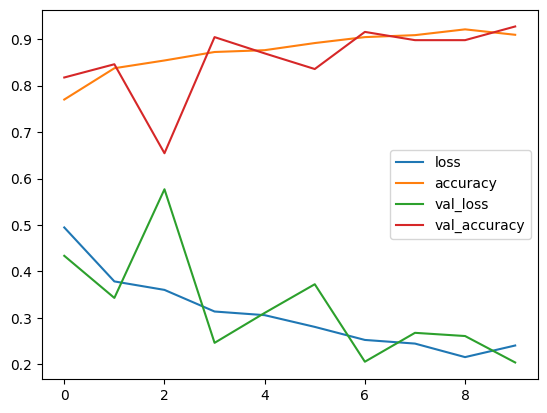

In [17]:
pd.DataFrame(history.history).plot()

In [19]:
gender_model.save("gender_model.keras")

In [20]:
y = np.array(data["Age"])
print(X.shape, y.shape)

(10702, 128, 128, 1) (10702,)


In [21]:
tensorflow.keras.backend.clear_session()
age_model = Sequential()

input_layer = Input((128, 128, 1))
c0 = Conv2D(4, 3, padding="same")(input_layer)
c0 = MaxPool2D(2)(c0)
c1 = create_block(c0, 16, 3)
c2 = create_block(c1, 32, 3)
c3 = create_block(c2, 64, 3)
c4 = create_block(c3, 128, 3)
c5 = create_block(c4, 64, 3)
c6 = create_block(c5, 32, 3)
c6 = GlobalAveragePooling2D()(c6)
c7 = tensorflow.keras.layers.Flatten()(c6)
c8 = Dense(100, activation="linear")(c7)
c9 = Dense(50, activation="linear")(c8)
output_layer = Dense(1, activation="linear")(c9)
age_model = Model(inputs=[input_layer], outputs=[output_layer])

In [22]:
age_model.compile(loss="mean_squared_error", optimizer="adam", metrics="mse")
age_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 4)       40        
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        592       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 16)        64    

In [23]:
history = age_model.fit(
    X, y,
    steps_per_epoch=(10000//10),
    validation_split=0.2,
    epochs=5
)

Epoch 1/5
1000/1000 [==============================] - 65s 61ms/step - loss: 393.4628 - mse: 393.4628 - val_loss: 215.0596 - val_mse: 215.0596
Epoch 2/5
1000/1000 [==============================] - 57s 57ms/step - loss: 229.4446 - mse: 229.4446 - val_loss: 161.2644 - val_mse: 161.2644
Epoch 3/5
1000/1000 [==============================] - 57s 57ms/step - loss: 201.4982 - mse: 201.4982 - val_loss: 204.3481 - val_mse: 204.3481
Epoch 4/5
1000/1000 [==============================] - 59s 59ms/step - loss: 187.9760 - mse: 187.9760 - val_loss: 202.6965 - val_mse: 202.6965
Epoch 5/5
 759/1000 [=====================>........] - ETA: 12s - loss: 178.8858 - mse: 178.8858

1000/1000 [==============================] - 44s 44ms/step - loss: 178.8534 - mse: 178.8534 - val_loss: 149.3301 - val_mse: 149.3301


<Axes: >

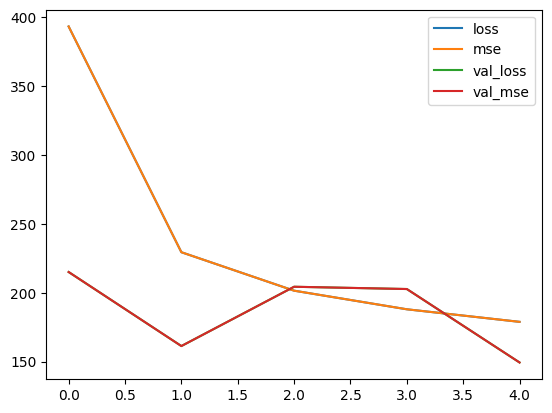

In [24]:
pd.DataFrame(history.history).plot()

In [25]:
age_model.save("age_model.keras")

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = gender_model.predict(X)
pred = []
for i in tqdm(y_pred):
  if i<0.5:
    pred.append(0)
  else:
    pred.append(1)
pred = np.array(pred)
print(pred.shape, y.shape)
print(pred[5:15], gender[5:15])

335/335 [==============================] - 24s 71ms/step


100%|██████████| 10702/10702 [00:00<00:00, 351242.93it/s]

(10702,) (10702,)
[1 1 1 0 1 1 1 1 0 1] 5     1
6     1
7     1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
Name: gender, dtype: int64


In [27]:
pred = np.round(age_model.predict(X))
print(pred[5:15], age[5:15])

335/335 [==============================] - 25s 74ms/step
[[68.]
 [41.]
 [34.]
 [68.]
 [41.]
 [58.]
 [59.]
 [50.]
 [65.]
 [37.]] 5     62.0
6     52.0
7     46.0
8     83.0
9     33.0
10    82.0
11    78.0
12    61.0
13    74.0
14    28.0
Name: age, dtype: float64


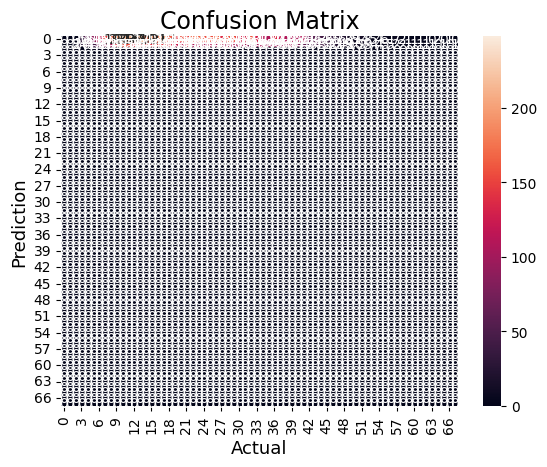

Accuracy:  0.0
Precision:  0.0
Recall:  0.0
F1 Score:  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import seaborn as sns

cm = confusion_matrix(gender, pred)

sns.heatmap(cm, annot=True, fmt="g")

plt.ylabel("Prediction", fontsize=13)
plt.xlabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17)
plt.show()

accuracy = accuracy_score(gender, pred)
print("Accuracy: ", accuracy)

precision = precision_score(gender, pred, average="weighted")
print("Precision: ", precision)

recall = recall_score(gender, pred, average="weighted")
print("Recall: ", recall)

F1_score = f1_score(gender, pred, average="weighted")
print("F1 Score: ", F1_score)

In [29]:
from sklearn.metrics import r2_score
p = age_model.predict(X)
print(r2_score(age, p))

335/335 [==============================] - 26s 79ms/step
0.5359258934623431
